In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_columns', None)

In [2]:
TRAINING_DATA_PATH = '/scratch/data/TrojAI/round7-train-dataset/'
RESULTS = 'results'

def get_metadata():
    metadata = pd.read_csv(join(TRAINING_DATA_PATH, 'METADATA.csv'))
    return metadata


def get_trigger_text(model_name):
    with open (join(TRAINING_DATA_PATH, 'models', model_name, 'config.json')) as json_file:
        config = json.load(json_file)
    key = ''
    for k in config['triggers'][0]['trigger_executor'].keys():
        if 'trigger_text' in k:
            return config['triggers'][0]['trigger_executor'][k]


def get_trigger_source_and_target(model_name):
    poisoned_file = os.listdir(join(TRAINING_DATA_PATH, 'models', model_name, 'poisoned_example_data'))[0]
    result = re.findall(r'source_class_(\d+)_target_class_(\d+)_', poisoned_file)
    return result

def id_str_to_model_id(id_str):
    id_str = str(100000000 + int(id_str))[1:]
    model_id = 'id-'+id_str
    return model_id

def get_all_files(path=RESULTS):
    df_list = []
    files = [f for f in os.listdir(path)]
    for f in files:
        temp_df = pd.read_csv(join(path, f))
        temp_df['model_name'] = id_str_to_model_id(f[:-4])
        df_list.append(temp_df)
    result = pd.concat(df_list)
    return result[['source_class', 'target_class', 'decoded_initial_candidate', 'decoded_top_candidate', 
                   'clean_asr', 'trigger_asr', 'loss', 'testing_loss', 'model_name']]

df = get_all_files()
metadata = get_metadata()

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_original_merged.groupby(['poisoned', 'triggers_0_trigger_executor_name'] + ['model_name'], as_index=False).count()\
    .groupby(['poisoned', 'triggers_0_trigger_executor_name']).agg({'model_name':'count'})


model_name
poisoned triggers_0_trigger_executor_name            
False    None                                      95
True     character                                 24
         phrase                                    24
         word1                                     24
         word2                                     24

In [3]:
asr_threshold = .9

df_original_merged = df.merge(metadata, how='left', on='model_name')

min_loss_df = df_original_merged.groupby('model_name', as_index=False).agg({'testing_loss':'min'})

def get_entry_with_min_loss(x):
    model_name = x['model_name']
    loss = x['testing_loss']
    asr = x['trigger_asr']
    min_loss = min_loss_df[min_loss_df['model_name'] == model_name]['testing_loss']
    # x['mask'] = ((loss==min_loss).item()) & (asr>asr_threshold)
    x['mask'] = ((loss==min_loss).item())
    return x

df_filtered = df_original_merged.apply(get_entry_with_min_loss, axis=1)
# df_original_merged['mask']
df_filtered = df_filtered[df_filtered['mask']]
df_filtered

df_filtered['trigger_type'] = pd.Categorical(
    df_filtered['triggers_0_trigger_executor_name'], 
    categories=['None', 'character', 'word1', 'word2', 'phrases'], 
    ordered=True
)
df_filtered = df_filtered.sort_values('trigger_type')

In [4]:
df_filtered[df_filtered.triggers_0_trigger_executor_name=='word1']

,source_class,target_class,decoded_initial_candidate,decoded_top_candidate,clean_asr,trigger_asr,loss,testing_loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged,mask,trigger_type
2515,1,5,up ! pants bad hey ok / briefly curse |,Nana coordinates convention [CLS] satellites c...,0.000000,1.000000,0.000637,0.010797,id-00000155,True,1888178055,1,WarmupWithLinear,1,0,NerLinear,0,0.00010,0,8,0.01,5,0.2,1,DistilBERT,0,distilbert-base-cased,2,conll2003,0,0.1,0,one2one,1,9,{'0': 'MISC' '1': 'PER' '2': 'ORG' '3': 'LOC'},MISC,ORG,0,0.2,1,False,1,word1,0.003886,0.132738,0.069338,0.06339967465805785,10,1531.613258,52.423666,99.530953,94.085880,93.929784,94.24197567724039,91.458471,93.99779069710594,100.0,100.0,0.9884105960264901,0.9318181818181818,0.9376299376299376,0.9347150259067357,MISC,0.9285714285714286,0.8863636363636364,0.9285714285714286,0.9069767441860465,PER,0.9239130434782609,0.9659090909090909,0.9239130434782609,0.9444444444444444,ORG,0.9289099526066351,0.9032258064516129,0.9289099526066351,0.9158878504672897,LOC,0.9632352941176471,0.9703703703703703,0.9632352941176471,0.9

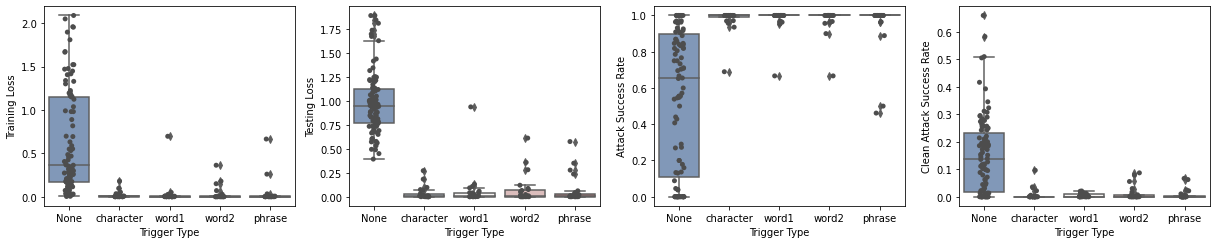

In [5]:
fig, axs = plt.subplots(1,4, figsize=(17,3.5))
ax=axs[0]
sns.boxplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Training Loss')

ax=axs[1]
sns.boxplot(data=df_filtered, y='testing_loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='testing_loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Testing Loss')

ax=axs[2]
sns.boxplot(data=df_filtered, y='trigger_asr', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='trigger_asr', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Attack Success Rate')

ax=axs[3]
sns.boxplot(data=df_filtered, y='clean_asr', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='clean_asr', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Clean Attack Success Rate')

for ax in axs:
    ax.set_xlabel('Trigger Type')

plt.tight_layout()
plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [6]:
df_original_merged = df.merge(metadata, how='left', on='model_name')

trigger_threshold = 0.6
clean_asr_threshold = .3
loss_threshold = .6
filtered_df = df_original_merged[(df_original_merged['trigger_asr']>trigger_threshold) & 
                                 (df_original_merged['clean_asr']<clean_asr_threshold) & 
                                 (df_original_merged['testing_loss']<loss_threshold)]
tagged_poisoned = filtered_df.groupby(['model_name'], as_index=False).first().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'}).rename(columns={'model_name':'tagged_poisoned'})

total = df_original_merged.groupby(['model_name'], as_index=False).first().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'}).rename(columns={'model_name':'total_models'})

result = total.merge(tagged_poisoned, on='triggers_0_trigger_executor_name', how='left')
result['pct_tagged_poisoned'] = result['tagged_poisoned']/result['total_models']
result.index.names = ['Trigger Type']
result.sort_values('pct_tagged_poisoned', ascending=False)

,total_models,tagged_poisoned,pct_tagged_poisoned
Trigger Type,,,
character,24,24,1.000000
word1,24,23,0.958333
word2,24,23,0.958333
phrase,24,22,0.916667
None,95,3,0.031579


In [7]:
filtered_df[filtered_df.triggers_0_trigger_executor_name == 'word1'].sort_values('testing_loss')
# filtered_df.sort_values('testing_loss')

,source_class,target_class,decoded_initial_candidate,decoded_top_candidate,clean_asr,trigger_asr,loss,testing_loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
1152,7,9,up ! pants bad hey ok / briefly curse |,nagoya bewildered yesterday ##fahan ##ע ok isb...,0.000000,1.000000,0.000014,0.000014,id-00000182,True,1529779093,0,CyclicLR,1,0,NerLinear,0,0.00010,0,8,0.01,5,0.2,3,MobileBERT,0,google/mobilebert-uncased,1,ontonotes-5.0,0,0.1,0,one2one,1,13,{'0': 'GPE' '1': 'PERSON' '2': 'DATE' '3': 'MO...,MONEY,NORP,0,0.2,0,True,1,word1,0.006632,0.190269,0.072432,0.11783686392092411,11,29505.540234,877.507267,98.999579,93.658881,93.197175,94.12058652472913,90.709664,96.48808896802038,100.0,100.0,0.9790404453905355,0.9205882352941176,0.9192364170337739,0.9199118295371052,GPE,0.9560439560439561,0.9354838709677419,0.9560439560439561,0.9456521739130435,PERSON,0.9761904761904762,0.8913043478260869,0.9761904761904762,0.9318181818181818,DATE,0.896551724137931,0.9285714285714286,0.896551724137931,0.912280701754386,MONEY,None,None,None,None,NORP,0.9024390243902439,0.9051987767584098,0.9024

['classifier.joblib']

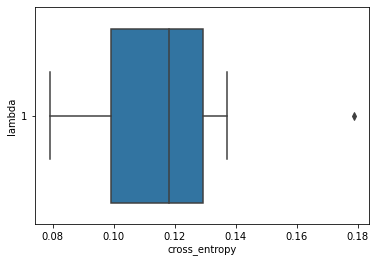

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.utils import shuffle

X = df_filtered[['testing_loss', 'clean_asr', 'trigger_asr']]
y = df_filtered['poisoned']

plt_df = pd.DataFrame(columns=['cross_entropy', 'lambda'])
for i in range(10):
    data = shuffle(df_filtered)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    plt_df.loc[len(plt_df)] = [log_loss(y_test, preds), '1']

sns.boxplot(data=plt_df, x='cross_entropy', y='lambda')


from joblib import dump, load

clf = LogisticRegression(random_state=0).fit(X, y)
dump(clf, 'classifier.joblib')



In [9]:
preds = clf.predict_proba(X_test)
preds

array([[0.05870443, 0.94129557],
       [0.99067504, 0.00932496],
       [0.07469707, 0.92530293],
       [0.88563029, 0.11436971],
       [0.06195519, 0.93804481],
       [0.06937327, 0.93062673],
       [0.95834237, 0.04165763],
       [0.87485454, 0.12514546],
       [0.9252063 , 0.0747937 ],
       [0.08466415, 0.91533585],
       [0.95214869, 0.04785131],
       [0.83935965, 0.16064035],
       [0.0597162 , 0.9402838 ],
       [0.85316814, 0.14683186],
       [0.06332672, 0.93667328],
       [0.06003262, 0.93996738],
       [0.78904147, 0.21095853],
       [0.87526305, 0.12473695],
       [0.96209637, 0.03790363],
       [0.92858404, 0.07141596],
       [0.99788479, 0.00211521],
       [0.88674791, 0.11325209],
       [0.0607748 , 0.9392252 ],
       [0.77307119, 0.22692881],
       [0.98820401, 0.01179599],
       [0.83032731, 0.16967269],
       [0.0595105 , 0.9404895 ],
       [0.93325425, 0.06674575],
       [0.96366025, 0.03633975],
       [0.9687164 , 0.0312836 ],
       [0.

In [4]:
model_name = 'id-00000190'
print(get_trigger_text(model_name))
print(get_trigger_source_and_target(model_name))

nascent
[('1', '7')]


In [18]:
filtered_df

,source_class,target_class,decoded_initial_candidate,decoded_top_candidate,clean_asr,trigger_asr,loss,testing_loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
1,1,5,ok ok ok ok ok ok ok,https pmid ##hema ##tem ##itia ##logist ##ize,0.000000,0.942857,0.357651,0.353236,id-00000025,True,1980238116,1,WarmupWithLinear,1,0,NerLinear,1,0.00005,0,8,0.01,5,0.2,0,BERT,0,bert-base-uncased,1,ontonotes-5.0,0,0.1,0,one2one,1,13,{'0': 'GPE' '1': 'PERSON' '2': 'DATE' '3': 'MO...,PERSON,DATE,0,0.2,1,False,3,word2,0.004557,0.124013,0.076309,0.047704338210639,10,36811.460496,989.775895,99.235318,95.860596,95.214788,96.50640345297182,93.766983,94.50335443577531,100.0,100.0,0.9919925076094591,0.9476940382452194,0.9661697247706422,0.9568427030096535,GPE,0.9680511182108626,0.9619047619047619,0.9680511182108626,0.964968152866242,PERSON,0.9680365296803652,0.925764192139738,0.9680365296803652,0.9464285714285714,DATE,0.9744597249508841,0.9593810444874274,0.9744597249508841,0.9668615984405458,MONEY,0.9375,0.8571428571428571,0.9375,0.8955223880597014,NORP,0.9148936170212766,0.8896551724137931,0.914